### 1. 훈련 데이터를 분류하여 복사

In [18]:
import os, shutil
import tensorflow as tf


In [2]:
original_dataset_path = './dogsNcats'
copy_train_path = './datasets'

In [3]:
def copy_files(dogORcat_path,start_num,end_num,trainOrval_path):
    
    image_paths = [os.path.join(original_dataset_path,"train",dogORcat_path + '.' + str(i) + '.jpg')
                  for i in range(start_num,end_num)]
    
    target_copy_paths = os.path.join(copy_train_path,trainOrval_path,dogORcat_path)
    
    if not os.path.isdir(target_copy_paths):
        os.makedirs(target_copy_paths)
        
    for image_path in image_paths:
        shutil.copy(image_path, target_copy_paths)
        
    print("데이터 복사가 완료되었습니다.")
    


In [4]:
copy_files("dog",0,10000,"train")
copy_files("cat",0,10000,"train")
copy_files("dog",10000,12500,"validation")
copy_files("cat",10000,12500,"validation")

데이터 복사가 완료되었습니다.
데이터 복사가 완료되었습니다.
데이터 복사가 완료되었습니다.
데이터 복사가 완료되었습니다.


In [5]:
print("훈련데이터 Dog 개수",len(os.listdir('./datasets/train/dog')))
print("훈련데이터 Cat 개수",len(os.listdir('./datasets/train/cat')))
print("검증데이터 Dog 개수",len(os.listdir('./datasets/validation/dog')))
print("검증데이터 Cat 개수",len(os.listdir('./datasets/validation/cat')))

훈련데이터 Dog 개수 10000
훈련데이터 Cat 개수 10000
검증데이터 Dog 개수 2500
검증데이터 Cat 개수 2500


### 2. 콜백 함수 만들기

In [4]:
from datetime import datetime
import os
import keras


Using TensorFlow backend.


In [5]:
save_dir = './my_log'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

    
project_name = 'dog_cat_CNN_model'

In [6]:
def save_file():
    time = datetime.today()
    yy = time.year
    mon = time.month
    dd = time.day
    hh = time.hour
    mm = time.minute
    sec = time.second
    time_name = str(yy) +  str(mon) + str(dd) + str(hh) + str(mm) +  str(sec) +'_my_' + project_name + '_model.h5'
    file_name = os.path.join(save_dir,time_name)
    return file_name


In [7]:
callbacks = [
    
    keras.callbacks.TensorBoard(
    log_dir = save_dir,
    write_graph=True,
    write_images=True
    ),
    
    keras.callbacks.EarlyStopping(
    monitor = 'val_acc',
        patience=10,
    ),
    keras.callbacks.ModelCheckpoint(
    filepath= save_file(),
    monitor = 'val_loss',
    save_best_only = True,
    )
]

### 3. 모델 구성

In [8]:
from keras import Input
from keras import layers ,models, losses ,optimizers

In [13]:
batch_size = 8
no_classes = 1
epochs = 20
image_height, image_width = 150,150
input_shape = (image_height,image_width,3)

In [15]:
def cnn_api(input_shape):
    
    input_tensor =Input(input_shape, name = "input")
    
    x = layers.Conv2D(filters= 32 ,kernel_size= (3,3) , padding= "same", activation='relu')(input_tensor)  
    x = layers.Conv2D(filters= 64 ,kernel_size= (3,3) , padding= "same", activation='relu')(x) 
   # x = layers.Conv2D(filters= 128 ,kernel_size= (3,3) , padding= "same", activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(units= 1024 , activation='relu')(x)
    
    output_tensor = layers.Dense(units= no_classes, activation= 'sigmoid', name= "output")(x)
    
    model = models.Model([input_tensor],[output_tensor])
    
    model.compile(loss = losses.binary_crossentropy, optimizer= optimizers.RMSprop(lr=0.0001), metrics=['acc'])
    return model
    

### 4. 데이터 전처리

In [11]:
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [20]:
train_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255) # 검증데이터 스케일 조정만 합니다.

train_generator = train_datagen.flow_from_directory(
    os.path.join(copy_train_path,"train"),
    target_size = (image_height, image_height),
    batch_size = batch_size,
    class_mode = "binary"
    )
validation_generator = val_datagen.flow_from_directory(
    os.path.join(copy_train_path,"validation"),
    target_size = (image_height, image_height),
    batch_size = batch_size,
    class_mode = "binary"
    )
    
newType_model = cnn_api(input_shape)
hist = newType_model.fit_generator(train_generator, steps_per_epoch = 20000//batch_size, epochs= epochs,
                                  validation_data = validation_generator, validation_steps = 5000//batch_size,
                                  callbacks = callbacks)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


ResourceExhaustedError: OOM when allocating tensor with shape[1440000,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]

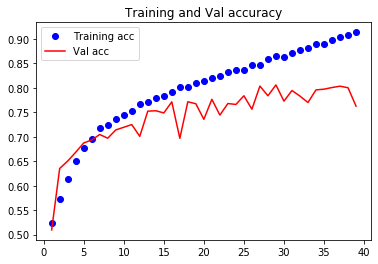

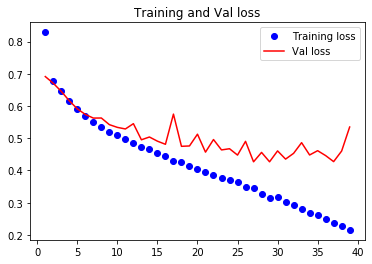

In [23]:
import matplotlib.pyplot as plt
train_acc = hist.history['acc']
val_acc = hist.history['val_acc']

train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1,len(train_acc)+1)

plt.plot(epochs,train_acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'r',label='Val acc')
plt.title('Training and Val accuracy')
plt.legend()

plt.figure()
plt.plot(epochs,train_loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Val loss')
plt.title('Training and Val loss')
plt.legend()

plt.show()

### 5-1 과대적합 - dropout, Maxpooling2d적용

In [27]:
from datetime import datetime
import os
import keras

save_dir = './my_log'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

    
project_name = 'dog_cat_CNN_api2_model'

def save_file():
    time = datetime.today()
    yy = time.year
    mon = time.month
    dd = time.day
    hh = time.hour
    mm = time.minute
    sec = time.second
    time_name = str(yy) +  str(mon) + str(dd) + str(hh) + str(mm) +  str(sec) +'_my_' + project_name + '_model.h5'
    file_name = os.path.join(save_dir,time_name)
    return file_name

callbacks = [
    
    keras.callbacks.TensorBoard(
    log_dir = save_dir,
    write_graph=True,
    write_images=True
    ),
    
    keras.callbacks.EarlyStopping(
    monitor = 'val_acc',
        patience=10,
    ),
    keras.callbacks.ModelCheckpoint(
    filepath= save_file(),
    monitor = 'val_loss',
    save_best_only = True,
    )
]




In [28]:
from keras import Input
from keras import layers ,models, losses ,optimizers

batch_size = 256
no_classes = 1
epochs = 50
image_height, image_width = 150,150
input_shape = (image_height,image_width,3)


In [29]:
#MaxPolling2d,Dropout 적용

def cnn_api2(input_shape):
    
    input_tensor =Input(input_shape, name = "input")
    
    x = layers.Conv2D(filters= 32 ,kernel_size= (3,3) , padding= "same", activation='relu')(input_tensor)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Dropout(rate=0.25)(x)
    
    x = layers.Conv2D(filters= 64 ,kernel_size= (3,3) , padding= "same", activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Dropout(rate=0.25)(x)
    
    x = layers.Conv2D(filters= 128 ,kernel_size= (3,3) , padding= "same", activation='relu')(x)
    x = layers.MaxPooling2D(pool_size= (2,2))(x)
    x = layers.Dropout(rate= 0.25)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(units= 1024 , activation='relu')(x)
    x = layers.Dropout(rate= 0.25)(x)
    
    output_tensor = layers.Dense(units= no_classes, activation= 'sigmoid', name= "output")(x)
    
    model = models.Model([input_tensor],[output_tensor])
    
    model.compile(loss = losses.binary_crossentropy, optimizer= optimizers.RMSprop(lr=0.0001), metrics=['acc'])
    return model

In [30]:
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image

train_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255) # 검증데이터 스케일 조정만 합니다.

train_generator = train_datagen.flow_from_directory(
    os.path.join(copy_train_path,"train"),
    target_size = (image_height, image_height),
    batch_size = batch_size,
    class_mode = "binary"
    )
validation_generator = val_datagen.flow_from_directory(
    os.path.join(copy_train_path,"validation"),
    target_size = (image_height, image_height),
    batch_size = batch_size,
    class_mode = "binary"
    )

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [31]:
newType_model = cnn_api2(input_shape)
hist = newType_model.fit_generator(train_generator, steps_per_epoch = 20000//batch_size, epochs= epochs,
                                  validation_data = validation_generator, validation_steps = 5000//batch_size,
                                  callbacks = callbacks)

Epoch 1/50
78/78 [==============================] - 24s 314ms/step - loss: 0.7122 - acc: 0.5487 - val_loss: 0.6664 - val_acc: 0.6125
Epoch 2/50
78/78 [==============================] - 22s 282ms/step - loss: 0.6437 - acc: 0.6159 - val_loss: 0.6372 - val_acc: 0.6771
Epoch 3/50
78/78 [==============================] - 22s 283ms/step - loss: 0.5970 - acc: 0.6757 - val_loss: 0.5904 - val_acc: 0.7104
Epoch 4/50
78/78 [==============================] - 22s 281ms/step - loss: 0.5669 - acc: 0.7038 - val_loss: 0.5586 - val_acc: 0.7323
Epoch 5/50
78/78 [==============================] - 22s 282ms/step - loss: 0.5433 - acc: 0.7227 - val_loss: 0.5354 - val_acc: 0.7380
Epoch 6/50
78/78 [==============================] - 22s 282ms/step - loss: 0.5260 - acc: 0.7367 - val_loss: 0.5197 - val_acc: 0.7458
Epoch 7/50
78/78 [==============================] - 22s 280ms/step - loss: 0.5037 - acc: 0.7499 - val_loss: 0.5476 - val_acc: 0.6981
Epoch 8/50
78/78 [==============================] - 22s 285ms/step - 

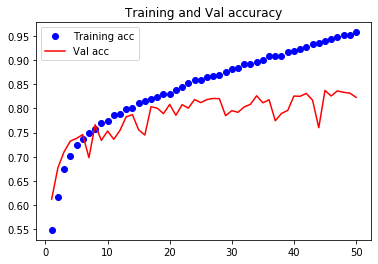

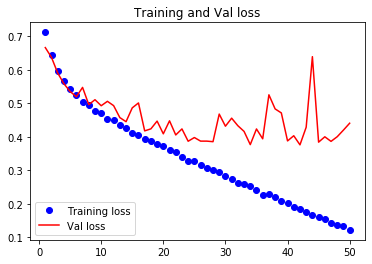

In [32]:
import matplotlib.pyplot as plt
train_acc = hist.history['acc']
val_acc = hist.history['val_acc']

train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1,len(train_acc)+1)

plt.plot(epochs,train_acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'r',label='Val acc')
plt.title('Training and Val accuracy')
plt.legend()

plt.figure()
plt.plot(epochs,train_loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Val loss')
plt.title('Training and Val loss')
plt.legend()

plt.show()

### 과대적합 5-2 - 레이어 늘리기

In [1]:
original_dataset_path = './dogsNcats'
copy_train_path = './datasets'

from datetime import datetime
import os
import keras

save_dir = './my_log'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

    
project_name = 'dog_cat_CNN_api3_model'

def save_file():
    time = datetime.today()
    yy = time.year
    mon = time.month
    dd = time.day
    hh = time.hour
    mm = time.minute
    sec = time.second
    time_name = str(yy) +  str(mon) + str(dd) + str(hh) + str(mm) +  str(sec) +'_my_' + project_name + '_model.h5'
    file_name = os.path.join(save_dir,time_name)
    return file_name

callbacks = [
    
    keras.callbacks.TensorBoard(
    log_dir = save_dir,
    write_graph=True,
    write_images=True
    ),
    
    keras.callbacks.EarlyStopping(
    monitor = 'val_acc',
        patience=10,
    ),
    keras.callbacks.ModelCheckpoint(
    filepath= save_file(),
    monitor = 'val_loss',
    save_best_only = True,
    )
]


from keras import Input
from keras import layers ,models, losses ,optimizers

batch_size = 256
no_classes = 1
epochs = 50
image_height, image_width = 150,150
input_shape = (image_height,image_width,3)

def cnn_api3(input_shape):
    
    input_tensor =Input(input_shape, name = "input")
    
    x = layers.Conv2D(filters= 32 ,kernel_size= (3,3) , padding= "same", activation='relu')(input_tensor)
    x = layers.Conv2D(filters= 32 ,kernel_size= (3,3) , padding= "same", activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Dropout(rate=0.25)(x)
    
    x = layers.Conv2D(filters= 64 ,kernel_size= (3,3) , padding= "same", activation='relu')(x)
    x = layers.Conv2D(filters= 64 ,kernel_size= (3,3) , padding= "same", activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Dropout(rate=0.25)(x)
    
    x = layers.Conv2D(filters= 128 ,kernel_size= (3,3) , padding= "same", activation='relu')(x)
    x = layers.Conv2D(filters= 128 ,kernel_size= (3,3) , padding= "same", activation='relu')(x)
    x = layers.MaxPooling2D(pool_size= (2,2))(x)
    x = layers.Dropout(rate= 0.25)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(units= 1024 , activation='relu')(x)
    x = layers.Dropout(rate= 0.25)(x)
    
    output_tensor = layers.Dense(units= no_classes, activation= 'sigmoid', name= "output")(x)
    
    model = models.Model([input_tensor],[output_tensor])
    
    model.compile(loss = losses.binary_crossentropy, optimizer= optimizers.RMSprop(lr=0.0001), metrics=['acc'])
    return model


from keras.preprocessing.image import ImageDataGenerator
from PIL import Image

train_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255) # 검증데이터 스케일 조정만 합니다.

train_generator = train_datagen.flow_from_directory(
    os.path.join(copy_train_path,"train"),
    target_size = (image_height, image_height),
    batch_size = batch_size,
    class_mode = "binary"
    )
validation_generator = val_datagen.flow_from_directory(
    os.path.join(copy_train_path,"validation"),
    target_size = (image_height, image_height),
    batch_size = batch_size,
    class_mode = "binary"
    )


newType_model = cnn_api3(input_shape)
hist = newType_model.fit_generator(train_generator, steps_per_epoch = 20000//batch_size, epochs= epochs,
                                  validation_data = validation_generator, validation_steps = 5000//batch_size,
                                  callbacks = callbacks)



Using TensorFlow backend.


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
78/78 [==============================] - 30s 380ms/step - loss: 0.7303 - acc: 0.5301 - val_loss: 0.6854 - val_acc: 0.5728
Epoch 2/50
78/78 [==============================] - 27s 341ms/step - loss: 0.6578 - acc: 0.6108 - val_loss: 0.7069 - val_acc: 0.5228
Epoch 3/50
78/78 [==============================] - 26s 337ms/step - loss: 0.5966 - acc: 0.6728 - val_loss: 0.5615 - val_acc: 0.7205
Epoch 4/50
78/78 [==============================] - 26s 338ms/step - loss: 0.5567 - acc: 0.7108 - val_loss: 0.5864 - val_acc: 0.6678
Epoch 5/50
78/78 [==============================] - 26s 337ms/step - loss: 0.5342 - acc: 0.7318 - val_loss: 0.5324 - val_acc: 0.7205
Epoch 6/50
78/7

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

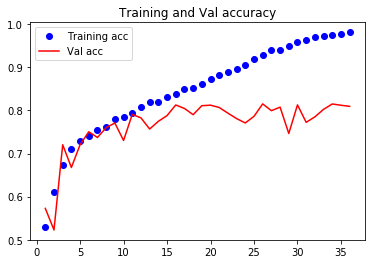

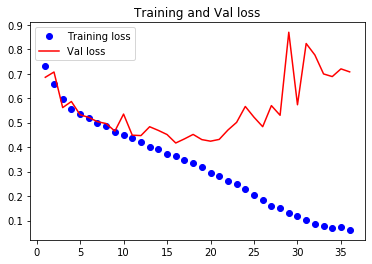

In [2]:

import matplotlib.pyplot as plt
train_acc = hist.history['acc']
val_acc = hist.history['val_acc']

train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1,len(train_acc)+1)

plt.plot(epochs,train_acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'r',label='Val acc')
plt.title('Training and Val accuracy')
plt.legend()

plt.figure()
plt.plot(epochs,train_loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Val loss')
plt.title('Training and Val loss')
plt.legend()

plt.show()

### 과대 적합 2 - 데이터 증식

In [ ]:
from datetime import datetime
import os
import keras

save_dir = './my_log'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

    
project_name = 'dog_cat_CNN_api3_datagen_model'

def save_file():
    time = datetime.today()
    yy = time.year
    mon = time.month
    dd = time.day
    hh = time.hour
    mm = time.minute
    sec = time.second
    time_name = str(yy) +  str(mon) + str(dd) + str(hh) + str(mm) +  str(sec) +'_my_' + project_name + '_model.h5'
    file_name = os.path.join(save_dir,time_name)
    return file_name

callbacks = [
    
    keras.callbacks.TensorBoard(
    log_dir = save_dir,
    write_graph=True,
    write_images=True
    ),
    
    keras.callbacks.EarlyStopping(
    monitor = 'val_acc',
        patience=10,
    ),
    keras.callbacks.ModelCheckpoint(
    filepath= save_file(),
    monitor = 'val_loss',
    save_best_only = True,
    )
]


from keras import Input
from keras import layers ,models, losses ,optimizers

batch_size = 256
no_classes = 1
epochs = 50
image_height, image_width = 150,150
input_shape = (image_height,image_width,3)

def cnn_api3(input_shape):
    
    input_tensor =Input(input_shape, name = "input")
    
    x = layers.Conv2D(filters= 32 ,kernel_size= (3,3) , padding= "same", activation='relu')(input_tensor)
    x = layers.Conv2D(filters= 32 ,kernel_size= (3,3) , padding= "same", activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Dropout(rate=0.25)(x)
    
    x = layers.Conv2D(filters= 64 ,kernel_size= (3,3) , padding= "same", activation='relu')(x)
    x = layers.Conv2D(filters= 64 ,kernel_size= (3,3) , padding= "same", activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Dropout(rate=0.25)(x)
    
    x = layers.Conv2D(filters= 128 ,kernel_size= (3,3) , padding= "same", activation='relu')(x)
    x = layers.Conv2D(filters= 128 ,kernel_size= (3,3) , padding= "same", activation='relu')(x)
    x = layers.MaxPooling2D(pool_size= (2,2))(x)
    x = layers.Dropout(rate= 0.25)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(units= 1024 , activation='relu')(x)
    x = layers.Dropout(rate= 0.25)(x)
    
    output_tensor = layers.Dense(units= no_classes, activation= 'sigmoid', name= "output")(x)
    
    model = models.Model([input_tensor],[output_tensor])
    
    model.compile(loss = losses.binary_crossentropy, optimizer= optimizers.RMSprop(lr=0.0001), metrics=['acc'])
    return model


from keras.preprocessing.image import ImageDataGenerator
from PIL import Image

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')


val_datagen = ImageDataGenerator(rescale = 1./255) # 검증데이터 스케일 조정만 합니다.

train_generator = train_datagen.flow_from_directory(
    os.path.join(copy_train_path,"train"),
    target_size = (image_height, image_height),
    batch_size = batch_size,
    class_mode = "binary"
    )
validation_generator = val_datagen.flow_from_directory(
    os.path.join(copy_train_path,"validation"),
    target_size = (image_height, image_height),
    batch_size = batch_size,
    class_mode = "binary"
    )


newType_model = cnn_api3(input_shape)
hist = newType_model.fit_generator(train_generator, steps_per_epoch = 20000//batch_size, epochs= epochs,
                                  validation_data = validation_generator, validation_steps = 5000//batch_size,
                                  callbacks = callbacks)


import matplotlib.pyplot as plt
train_acc = hist.history['acc']
val_acc = hist.history['val_acc']

train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1,len(train_acc)+1)

plt.plot(epochs,train_acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'r',label='Val acc')
plt.title('Training and Val accuracy')
plt.legend()

plt.figure()
plt.plot(epochs,train_loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Val loss')
plt.title('Training and Val loss')
plt.legend()

plt.show()

### Xception모델 사용

In [5]:
original_dataset_path = './dogsNcats'
copy_train_path = './datasets'

import tensorflow as tf
from keras.backend import tensorflow_backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))

from datetime import datetime
import os
import keras

save_dir = './my_log'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

    
project_name = 'dog_cat_xception_datagen_model'

def save_file():
    time = datetime.today()
    yy = time.year
    mon = time.month
    dd = time.day
    hh = time.hour
    mm = time.minute
    sec = time.second
    time_name = str(yy) +  str(mon) + str(dd) + str(hh) + str(mm) +  str(sec) +'_my_' + project_name + '_model.h5'
    file_name = os.path.join(save_dir,time_name)
    return file_name

callbacks = [
    
    keras.callbacks.TensorBoard(
    log_dir = save_dir,
    write_graph=True,
    write_images=True
    ),
    
    keras.callbacks.EarlyStopping(
    monitor = 'val_acc',
        patience=3,
    ),
    keras.callbacks.ModelCheckpoint(
    filepath= save_file(),
    monitor = 'val_loss',
    save_best_only = True,
    )
]


from keras import Input
from keras import layers ,models, losses ,optimizers

batch_size = 32
no_classes = 1
epochs = 10
image_height, image_width = 150,150
input_shape = (image_height,image_width,3)

from keras.applications import Xception
def xception_Model(input_shape):
    xceptionmodel = Xception(input_shape=input_shape, weights='imagenet', include_top=False)

    model = models.Sequential()
    model.add(xceptionmodel)
    model.add(layers.Flatten())
    model.add(layers.Dense(units=256, activation="relu"))
    model.add(layers.Dense(units=no_classes, activation="sigmoid"))

    model.compile(loss=losses.binary_crossentropy, optimizer=optimizers.RMSprop(), metrics=['acc'])
    return model


from keras.preprocessing.image import ImageDataGenerator
from PIL import Image

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')


val_datagen = ImageDataGenerator(rescale = 1./255) # 검증데이터 스케일 조정만 합니다.

train_generator = train_datagen.flow_from_directory(
    os.path.join(copy_train_path,"train"),
    target_size = (image_height, image_height),
    batch_size = batch_size,
    class_mode = "binary"
    )
validation_generator = val_datagen.flow_from_directory(
    os.path.join(copy_train_path,"validation"),
    target_size = (image_height, image_height),
    batch_size = batch_size,
    class_mode = "binary"
    )


with tf.device('gpu:0'):
    newType_model = xception_Model(input_shape)
hist = newType_model.fit_generator(train_generator, steps_per_epoch = 20000//batch_size, epochs= epochs,
                                  validation_data = validation_generator, validation_steps = 5000//batch_size,
                                  callbacks = callbacks)




Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 1/10
625/625 [==============================] - 164s 262ms/step - loss: 0.4160 - acc: 0.8303 - val_loss: 7.1174 - val_acc: 0.5212
Epoch 2/10
625/625 [==============================] - 156s 250ms/step - loss: 0.1986 - acc: 0.9271 - val_loss: 0.2250 - val_acc: 0.9501
Epoch 3/10
625/625 [==============================] - 145s 231ms/step - loss: 0.1600 - acc: 0.9412 - val_loss: 0.3221 - val_acc: 0.9370
Epoch 4/10
625/625 [==============================] - 134s 214ms/step - loss: 0.1669 - acc: 0.9454 - val_loss: 0.1293 - val_acc: 0.9505
Epoch 5/10
625/625 [==============================] - 133s 213ms/step - loss: 0.1478 - acc: 0.9480 - val_loss: 0.1062 - val_acc: 0.9595
Epoch 6/10
625/625 [==============================] - 133s 212ms/step - loss: 0.1292 - acc: 0.9548 - val_loss: 0.1116 - val_acc: 0.9678
Epoch 7/10
625/625 [==============================] - 134s 214ms/step - loss: 0.1199 - acc: 0.9587 

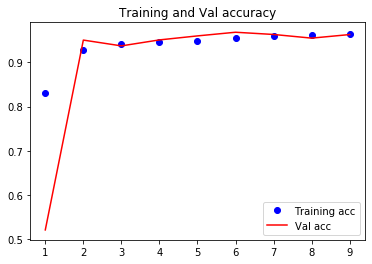

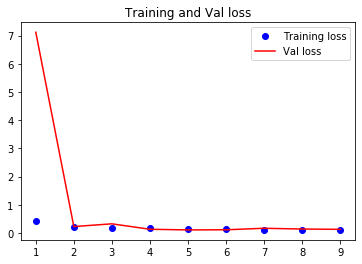

In [7]:
import matplotlib.pyplot as plt
train_acc = hist.history['acc']
val_acc = hist.history['val_acc']

train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1,len(train_acc)+1)

plt.plot(epochs,train_acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'r',label='Val acc')
plt.title('Training and Val accuracy')
plt.legend()

plt.figure()
plt.plot(epochs,train_loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Val loss')
plt.title('Training and Val loss')
plt.legend()

plt.show()

### 저장된 모델 불러오기 및 테스트 데이터 사용하기

In [11]:
from keras.models import load_model
type_model = load_model('/keras/my_log/20196141944_my_dog_cat_xception_datagen_model_model.h5')

from keras.preprocessing import image
import PIL
import os
import numpy as np

test_image_path = '/keras/dogsNcats/test1'
list_imgs= os.listdir(test_image_path)
sort_imgs_num = [i+1 for i in range(len(list_imgs))] #1.jpg부터 시작



test_image_path = '/keras/dogsNcats/test1'

#목록 갯수를 가져와서 1부터시작 하는 목록을 만듭니다. 
list_imgs= os.listdir(test_image_path)
sort_imgs_num = [i+1 for i in range(len(list_imgs))] #1.jpg부터 시작

test_image = []
for imgs in sort_imgs_num:
    img_path = os.path.join(test_image_path,str(imgs)+'.jpg') #원하는 목록리스트를 만듭니다.
    img = image.load_img(img_path,target_size=(150,150)) # 해당 파일 사이즈를 변경합니다.
    img_tensor = image.img_to_array(img)   # 해당 이미지를 배열로 바꿔 줍니다.
    img_tensor /= 255.     # 이미지데이터를 정규화(표준화) 합니다. 
    test_image.append(img_tensor)  #변환된 데이터를 리스트에 저장합니다.



In [14]:
image_array = np.array(test_image)
print("이미지 모양확인", image_array.shape)

이미지 모양확인 (12500, 150, 150, 3)


### 모델을 테스트 사진에 적용시킵시다

In [15]:
predictions = type_model.predict(image_array)

### 잠깐 이미지를 확인해 봅시다

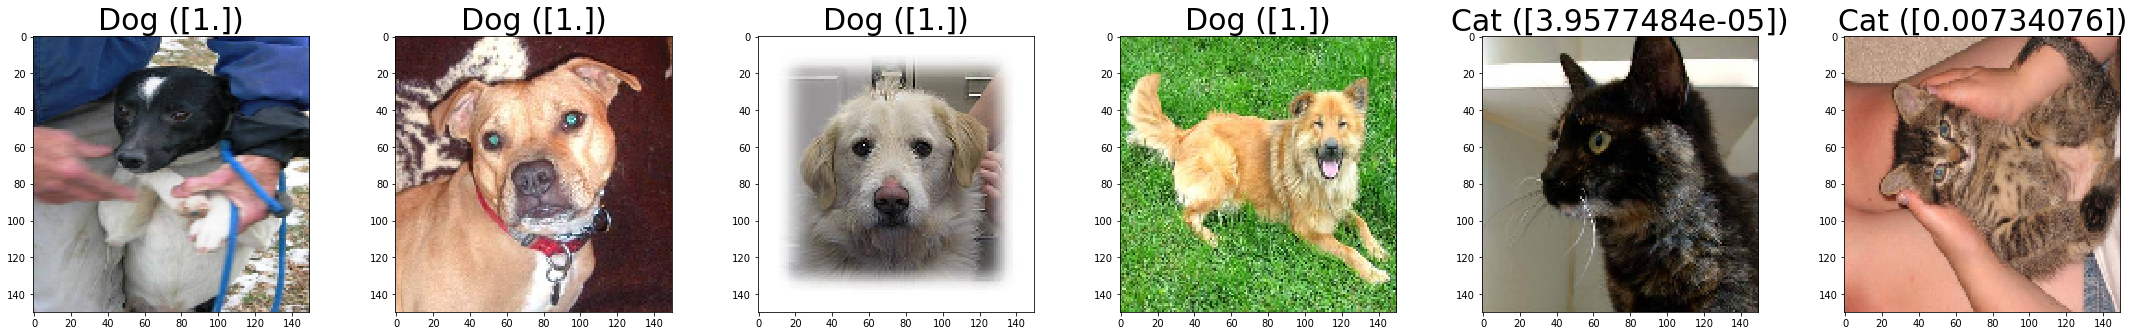

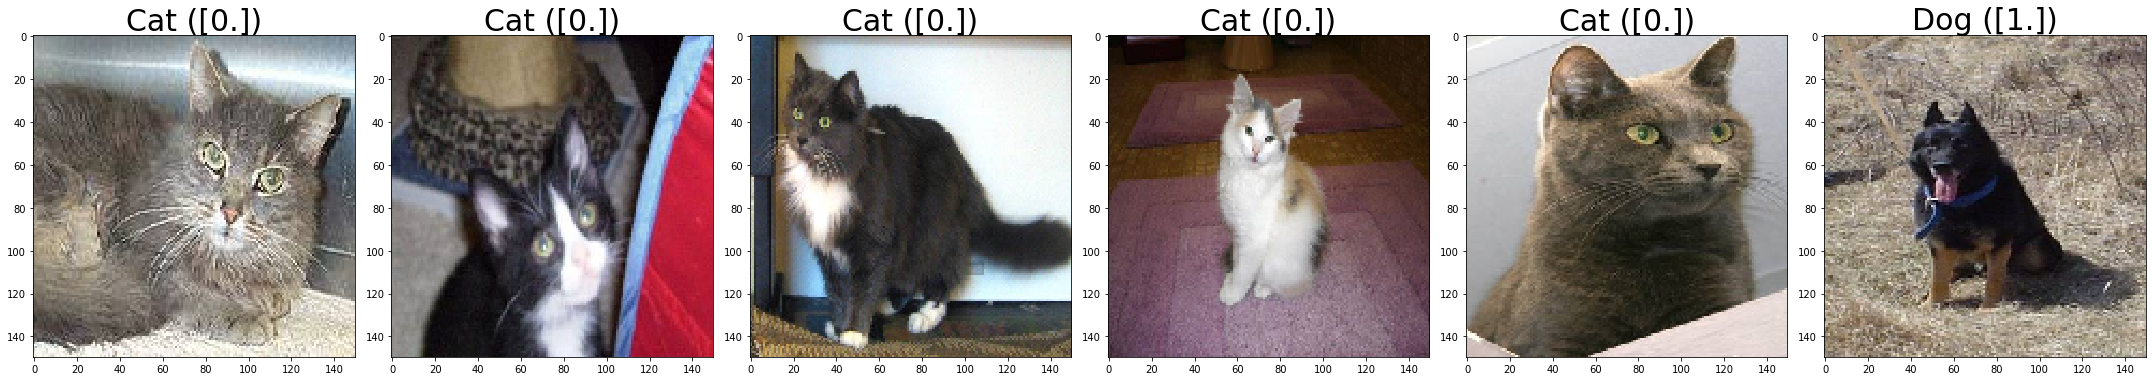

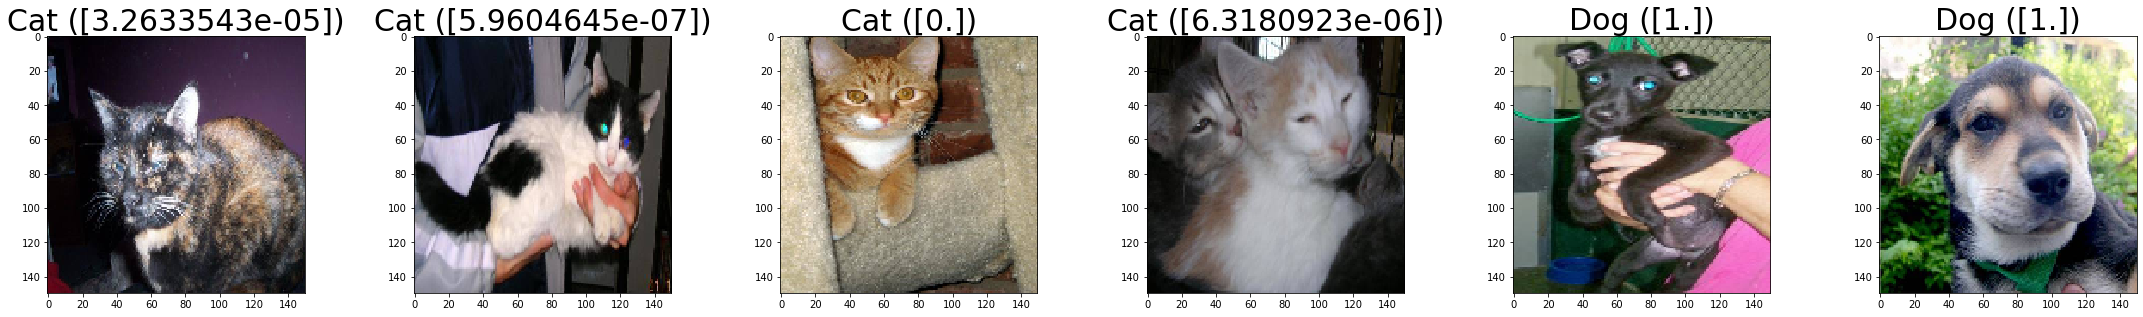

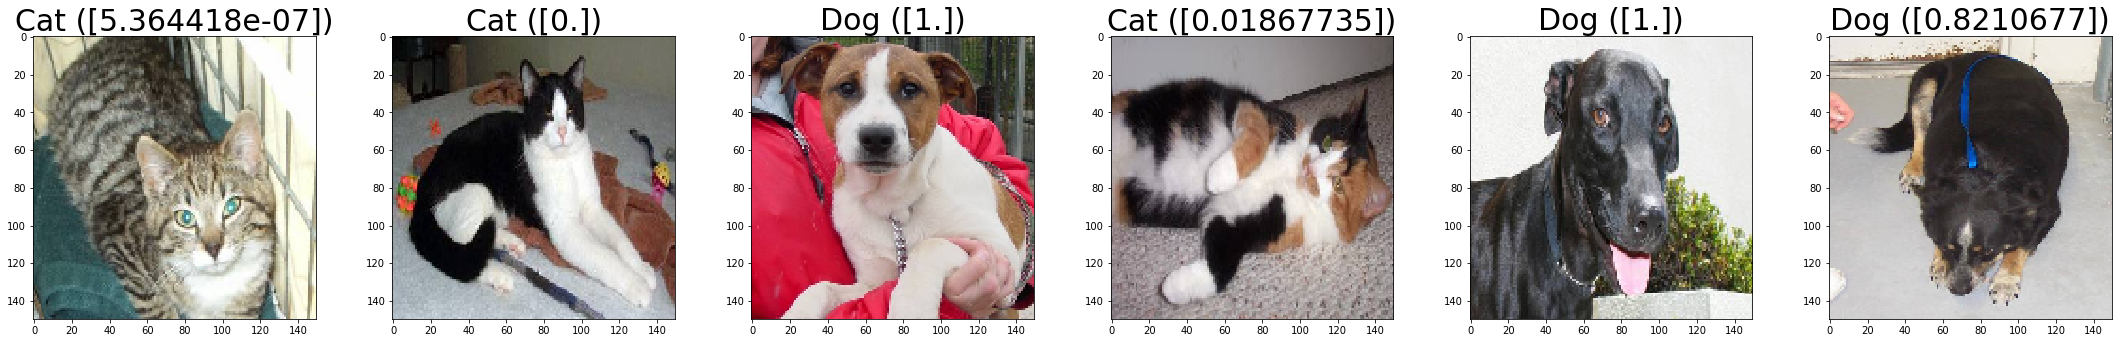

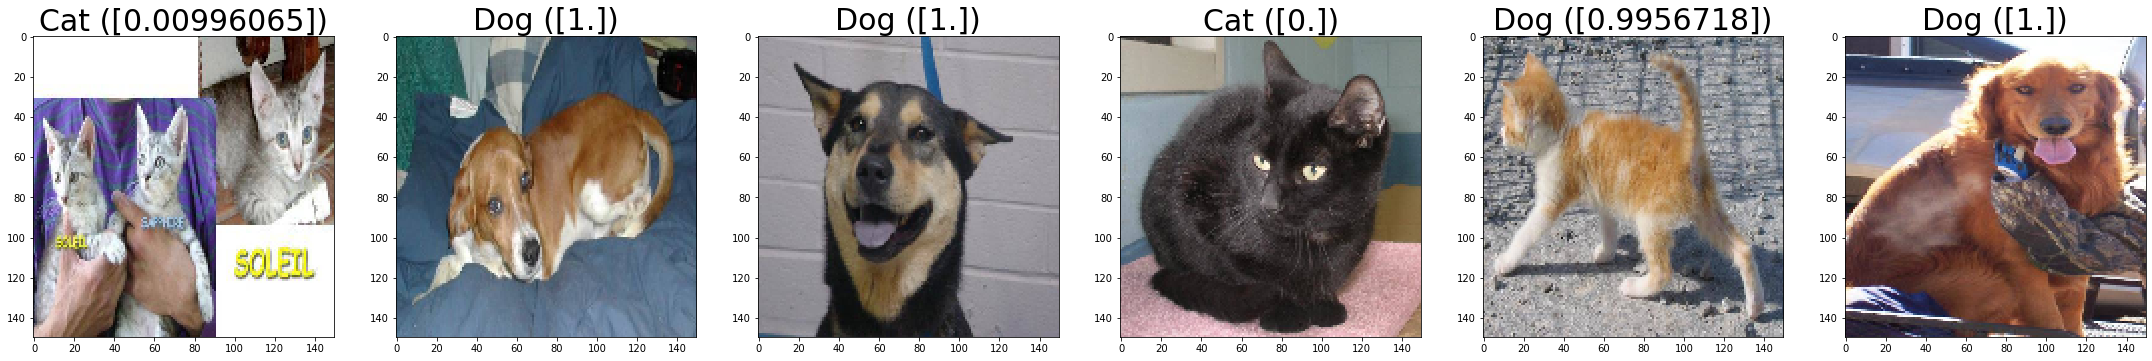

In [18]:


def plot_data(X, y, num_figures):
    plt.figure(figsize=(30, 20))

    for i in range(num_figures):
        plt.subplot(2, num_figures, i+1)

        plt.imshow(X[i])
        
        if y[i] >= 0.5:
            plt.title("Dog ("+ str(y[i]) + ")", fontsize=30)
        else:
            plt.title("Cat ("+ str(y[i]) + ")", fontsize=30)
            
    plt.tight_layout()
    plt.show() 
    
for i in range(0, 30, 6): 
    plot_data(test_image[i:], predictions[i:], 6)
    

###  실제 사진을 분류해 봅시다

In [19]:
import os, shutil

test_image_path = '/keras/dogsNcats/test1'
copy_testImage_path = '/keras/datasets/test'


#str(i+1) 이유는 테스트사진이 1.jpg 부터 시작
def test_copy_files(prefix_str,i):
    image_paths = os.path.join(test_image_path ,str(i+1)+'.jpg')
    data_dir = os.path.join(copy_testImage_path,prefix_str)
    
    if not os.path.isdir(data_dir):
        os.makedirs(data_dir)
        
    shutil.copy(image_paths,data_dir) 
    

# 사진 자동 분류하기


for i in range(len(predictions)):
    img = predictions[i]
    if img >= 0.5:
        test_copy_files("dog",i)
    else:
        test_copy_files("cat",i)

    
print("테스트 사진 분류 완료!") 

테스트 사진 분류 완료!


In [17]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10700822221095891011,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2204421324
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16966891338594818267
 physical_device_desc: "device: 0, name: GeForce GTX 1060 3GB, pci bus id: 0000:27:00.0, compute capability: 6.1"]